# Imports

In [27]:
data_path = 'data/hepatitis.data'

In [32]:
import pandas as pd
import numpy as np
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix
from sklearn.base import clone

from scipy.stats import ttest_ind

import matplotlib.patches as mpatches
from tabulate import tabulate

pd.set_option('display.max_rows', None)

# Load data

In [29]:
columns = ['class', 'age', 'sex', 'seroid', 'antviral',
           'fatigue', 'malaise', 'anorexia', 'liver_big', 'liver_firm',
           'spleen_palpable',  'spiders', 'ascites', 'varices', 'bilirubin', 
           'alk_phosphate', 'sgot', 'albumin', 'protime', 'histology']

columns_to_drop = ['alk_phosphate', 'protime']

df = pd.read_csv(data_path, names=columns)

## Sanitize data

In [30]:
# drop columns with many empty records
df = df.drop(columns_to_drop, axis=1)
# mark '?' as NaN
df = df[df != '?']
# drop NaN
df = df.dropna()
df = df.reset_index(drop=True)
# convert 'Object' type to floats and ints
df[['bilirubin', 'sgot', 'albumin']] = df[['bilirubin', 'sgot', 'albumin']].astype('float')
df[['class', 'sex', 'seroid', 'antviral', 'fatigue', 'malaise', 'anorexia', 'liver_big', 'liver_firm', 'spleen_palpable', 'spiders', 'ascites', 'varices', 'histology']] = df[['class', 'sex', 'seroid', 'antviral', 'fatigue', 'malaise', 'anorexia', 'liver_big', 'liver_firm', 'spleen_palpable', 'spiders', 'ascites', 'varices', 'histology']].astype(int)
# replace class marks
df.replace({1: 0, 2: 1}, inplace=True)
# divdie df to X and y sets
X = df.drop(['class'], axis=1)
y = df['class']

X.head()

0      1
1      1
2      1
3      1
4      1
5      1
6      1
7      1
8      1
9      1
10     1
11     1
12     1
13     1
14     1
15     1
16     1
17     1
18     1
19     1
20     1
21     1
22     1
23     1
24     1
25     1
26     0
27     1
28     1
29     1
30     0
31     1
32     1
33     1
34     1
35     1
36     1
37     1
38     1
39     1
40     1
41     1
42     1
43     1
44     1
45     1
46     1
47     1
48     1
49     1
50     1
51     1
52     1
53     1
54     1
55     1
56     1
57     0
58     1
59     1
60     1
61     1
62     1
63     1
64     0
65     1
66     1
67     1
68     1
69     1
70     1
71     1
72     1
73     0
74     0
75     1
76     1
77     0
78     1
79     0
80     1
81     1
82     1
83     0
84     0
85     1
86     1
87     0
88     1
89     1
90     0
91     1
92     0
93     1
94     1
95     1
96     1
97     1
98     1
99     0
100    1
101    1
102    1
103    1
104    0
105    1
106    0
107    1
108    0
109    1
110    1
1

,age,sex,seroid,antviral,fatigue,malaise,anorexia,liver_big,liver_firm,spleen_palpable,spiders,ascites,varices,bilirubin,sgot,albumin,histology
0,30,1,0,1,1,1,1,0,1,1,1,1,1,0.0,18.0,4.0,0
1,50,0,0,1,0,1,1,0,1,1,1,1,1,0.9,42.0,3.5,0
2,78,0,1,1,0,1,1,1,1,1,1,1,1,0.7,32.0,4.0,0
3,34,0,1,1,1,1,1,1,1,1,1,1,1,0.0,200.0,4.0,0
4,34,0,1,1,1,1,1,1,1,1,1,1,1,0.9,28.0,4.0,0


# Features ranking

In [6]:
# use chi-squared test to make features ranking
chi2_selector = SelectKBest(chi2, k=X.shape[1])
data = chi2_selector.fit(X, y)

## Ranking table

In [7]:
# create ranking table
chi2_scores = pd.DataFrame(list(zip(X.columns, chi2_selector.scores_)), columns=['feature', 'score'])
chi2_scores = chi2_scores.round(2)
chi2_scores = chi2_scores.sort_values('score', ascending=False)

## Bar plot

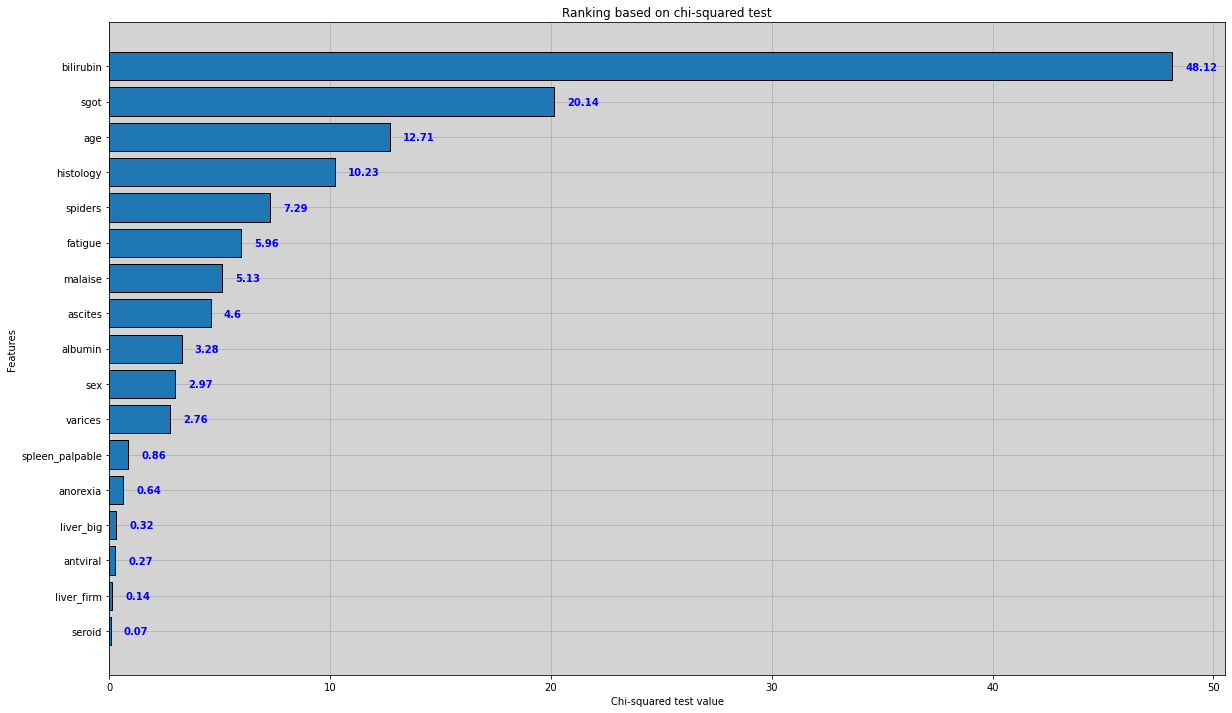

In [8]:
# display bar plot
plt.figure(figsize=(20,12))
plt.rcParams['axes.facecolor'] = 'lightgray'
plt.grid(zorder=0)
estimator_num = len(chi2_scores['feature'])

# sort ascending because horizontal bars print in reverse order
ascending_features = chi2_scores.sort_values('score', ascending=True)

# create horizontal bar plot
plt.barh(range(estimator_num), ascending_features['score'], align='center', zorder=3, edgecolor='black')

# label bars and axis
plt.yticks(range(estimator_num), ascending_features['feature'])
plt.title('Ranking based on chi-squared test')
plt.ylabel('Features')
plt.xlabel('Chi-squared test value')

# add scores at bars end
for i, v in enumerate(ascending_features['score']):
    plt.text(v + 0.6, i - 0.1, str(v), color='blue', fontweight='bold')

# save to file must be call before show
plt.savefig(fname='ranking.png', orientation='landscape')
plt.show()

In [9]:
# chi2_support = chi2_selector.get_support()
# chi2_feature = X.loc[:,chi2_support].columns.tolist()
# print(chi2_feature)

In [10]:
# X_norm_striped = MinMaxScaler().fit_transform(X[chi2_feature])
# df = pd.DataFrame(data=X[chi2_feature], columns=chi2_feature)
# df.head()

# Experimental environment

### Classifiers declaration

In [11]:
clfs = {
    '512_momentum': MLPClassifier(hidden_layer_sizes=512, verbose=True, max_iter=500, early_stopping=True, n_iter_no_change=20, solver='sgd',momentum=0.9),
    '256_momentum': MLPClassifier(hidden_layer_sizes=256, verbose=True, max_iter=500, early_stopping=True, n_iter_no_change=20, solver='sgd',momentum=0.9),
    '128_momentum': MLPClassifier(hidden_layer_sizes=128, verbose=True, max_iter=500, early_stopping=True, n_iter_no_change=20, solver='sgd',momentum=0.9),
    '512_no_momentum': MLPClassifier(hidden_layer_sizes=512, verbose=True, max_iter=500, early_stopping=True, n_iter_no_change=20, solver='adam', momentum=0),
    '256_no_momentum': MLPClassifier(hidden_layer_sizes=256, verbose=True, max_iter=500, early_stopping=True, n_iter_no_change=20, solver='adam', momentum=0),
    '128_no_momentum': MLPClassifier(hidden_layer_sizes=128, verbose=True, max_iter=500, early_stopping=True, n_iter_no_change=20, solver='adam', momentum=0)
}

In [12]:
n_splits = 2
n_repeats = 5
number_of_features = len(X.columns)
clfs_amount = len(clfs)

In [13]:
# result of every single k-fold 
f1_scores = np.zeros((len(clfs), number_of_features, n_splits * n_repeats))

### Model fitting with cross validation

In [14]:
rskf = RepeatedStratifiedKFold(n_splits=n_splits, n_repeats=n_repeats)

In [36]:

for features_index in range(number_of_features):
    k_best_selector = SelectKBest(chi2, k=features_index + 1)
    selected_data = k_best_selector.fit_transform(X, y)

    for fold_id, (train_index, test_index) in enumerate(rskf.split(selected_data, y)):
        for clf_id, clf_name in enumerate(clfs):
            X_train, X_test = selected_data[train_index], selected_data[test_index]
            y_train, y_test = y.iloc[train_index], y.iloc[test_index]
            clf = clfs[clf_name]
            clf.fit(X_train, y_train)
            y_pred = clf.predict(X_test)
            f1_scores[clf_id, features_index, fold_id] = f1_score(y_test, y_pred, average="binary")


ore: 0.857143
Iteration 25, loss = 0.47944870
Validation score: 0.857143
Validation score did not improve more than tol=0.000100 for 20 consecutive epochs. Stopping.
[0 1 1 1 1 1 1 0 1 0 1 0 1 1 1 1 1 0 0 0 0 1 1 1 0 1 1 1 0 1 1 1 1 0 1 1 1
 1 0 1 1 1 1 0 1 1 1 1 0 1 1 1 0 1 0 1 1 0 1 0 1 1 1 0]
Iteration 1, loss = 2.18852152
Validation score: 0.857143
Iteration 2, loss = 3.19140825
Validation score: 0.857143
Iteration 3, loss = 3.59856265
Validation score: 0.857143
Iteration 4, loss = 3.35950504
Validation score: 0.857143
Iteration 5, loss = 2.56145831
Validation score: 0.857143
Iteration 6, loss = 1.32044404
Validation score: 0.142857
Iteration 7, loss = 1.29977457
Validation score: 0.857143
Iteration 8, loss = 1.57134172
Validation score: 0.857143
Iteration 9, loss = 0.93585298
Validation score: 0.285714
Iteration 10, loss = 0.73907407
Validation score: 0.857143
Iteration 11, loss = 1.06485952
Validation score: 0.857143
Iteration 12, loss = 0.51800316
Validation score: 0.285714
Iter

In [16]:
means = np.mean(f1_scores, axis=2)

In [17]:
print("=== Classifier, features, k-fold mean ===")
for clf_id, clf_name in enumerate(clfs):
    print(f"--- Classifier: {clf_name} ---")
    for feature_index in range(number_of_features):
        cls_mean = means[clf_id,feature_index]
        print("Features: %d, mean: %.4f" % (feature_index+1, cls_mean))

=== Classifier, features, k-fold mean ===
--- Classifier: 512_momentum ---
Features: 1, mean: 0.8848
Features: 2, mean: 0.8972
Features: 3, mean: 0.8845
Features: 4, mean: 0.8868
Features: 5, mean: 0.8749
Features: 6, mean: 0.8866
Features: 7, mean: 0.8955
Features: 8, mean: 0.8974
Features: 9, mean: 0.8764
Features: 10, mean: 0.8769
Features: 11, mean: 0.8974
Features: 12, mean: 0.8629
Features: 13, mean: 0.8965
Features: 14, mean: 0.8841
Features: 15, mean: 0.8631
Features: 16, mean: 0.8974
Features: 17, mean: 0.8634
--- Classifier: 256_momentum ---
Features: 1, mean: 0.7830
Features: 2, mean: 0.8974
Features: 3, mean: 0.8914
Features: 4, mean: 0.8852
Features: 5, mean: 0.8876
Features: 6, mean: 0.8881
Features: 7, mean: 0.8912
Features: 8, mean: 0.8708
Features: 9, mean: 0.8966
Features: 10, mean: 0.8678
Features: 11, mean: 0.8877
Features: 12, mean: 0.8874
Features: 13, mean: 0.8794
Features: 14, mean: 0.8439
Features: 15, mean: 0.8870
Features: 16, mean: 0.8941
Features: 17, mean:

In [18]:
means.shape

(6, 17)

## Plots

### Plots with momentum

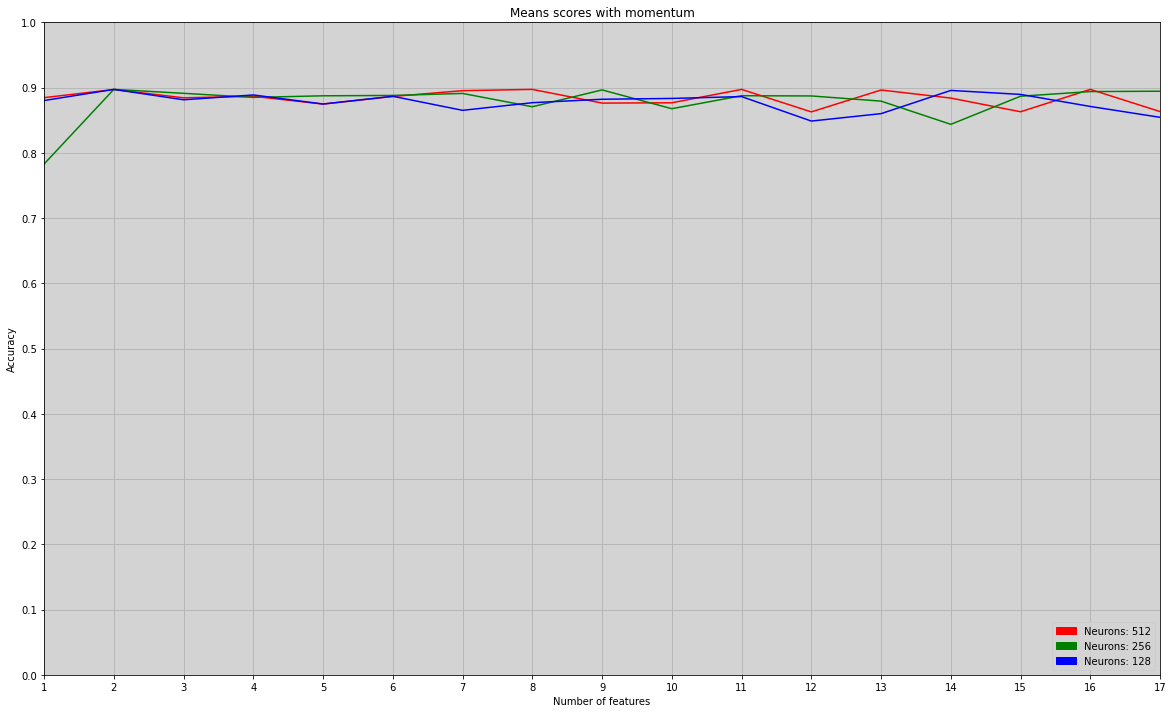

In [19]:
# display bar plot
plt.figure(figsize=(20,12))
plt.rcParams['axes.facecolor'] = 'lightgray'
plt.grid(zorder=0)

plot_x = np.arange(1, number_of_features+1)
# create horizontal bar plot
# plt.barh(range(estimator_num), ascending_features['score'], align='center', zorder=3, edgecolor='black')
colors = ['red', 'green', 'blue']
for clf_id, clf_name in enumerate(clfs):
    if clf_id < 3: # only with momentum
        plt.plot(plot_x, means[clf_id], colors[clf_id])

# label bars and axis
axes = plt.gca()
axes.set_xlim([1,number_of_features])
plt.yticks(np.arange(0, 1.1, 0.1))
plt.xticks(np.arange(1, number_of_features+1, 1))
plt.title('Means scores with momentum')
plt.ylabel('Accuracy')
plt.xlabel('Number of features')

red_patch = mpatches.Patch(color='red', label='Neurons: 512')
green_patch = mpatches.Patch(color='green', label='Neurons: 256')
blue_patch = mpatches.Patch(color='blue', label='Neurons: 128')
legend_patches=[red_patch,green_patch,blue_patch]

# save to file must be call before show
plt.savefig(fname='means-with-momentum.png', orientation='landscape')
plt.legend(handles=legend_patches,loc=4)
plt.show()


### Plots without momentum

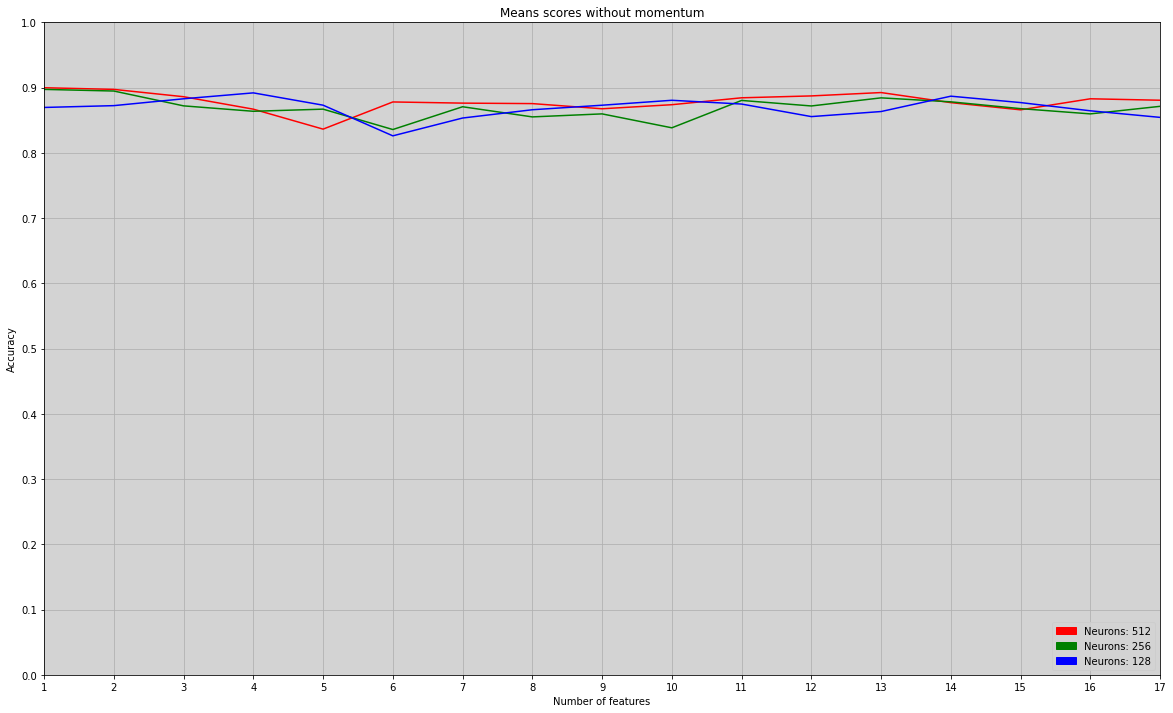

In [20]:
# display bar plot
plt.figure(figsize=(20,12))
plt.rcParams['axes.facecolor'] = 'lightgray'
plt.grid(zorder=0)

plot_x = np.arange(1, number_of_features+1)
# create horizontal bar plot
# plt.barh(range(estimator_num), ascending_features['score'], align='center', zorder=3, edgecolor='black')
colors = ['red', 'green', 'blue']
for clf_id, clf_name in enumerate(clfs):
    if clf_id < 3: # only with no momentum
        plt.plot(plot_x, means[clf_id+3], colors[clf_id])

# label bars and axis
axes = plt.gca()
axes.set_xlim([1,number_of_features])
plt.yticks(np.arange(0, 1.1, 0.1))
plt.xticks(np.arange(1, number_of_features+1, 1))
plt.title('Means scores without momentum')
plt.ylabel('Accuracy')
plt.xlabel('Number of features')

red_patch = mpatches.Patch(color='red', label='Neurons: 512')
green_patch = mpatches.Patch(color='green', label='Neurons: 256')
blue_patch = mpatches.Patch(color='blue', label='Neurons: 128')
legend_patches=[red_patch,green_patch,blue_patch]

# save to file must be call before show
plt.savefig(fname='means-without-momentum.png', orientation='landscape')
plt.legend(handles=legend_patches,loc=4)
plt.show()

# Statistical analysis 

In [21]:
t_statistics = np.zeros((number_of_features, clfs_amount, clfs_amount))
p_values = np.zeros((number_of_features, clfs_amount, clfs_amount))

In [23]:

for feat in range(number_of_features): # we compare every classifier with each other for every feature number
    for cls_a in range(clfs_amount):
        for cls_b in range(clfs_amount):
            a = f1_scores[cls_a][feat]
            b = f1_scores[cls_b][feat]
            t_statistics[feat][cls_a][cls_b], p_values[feat][cls_a][cls_b] = ttest_ind(a, b)

In [24]:

t_statistics = np.round(t_statistics, 2)
p_values = np.round(p_values, 2)

for feat in range(number_of_features): 
    print(f"=== Number of features: {feat} ===")
    for clf_a_id, clf_a_name in enumerate(clfs):
        for clf_b_id, clf_b_name in enumerate(clfs):
            print(f'\tClassifier {clf_a_name} compare to {clf_b_name}:')
            print(f'\tstatistic = {t_statistics[feat][clf_a_id][clf_b_id]}, pvalue = {p_values[feat][clf_a_id][clf_b_id]}')
            print()



56_no_momentum compare to 512_momentum:
	statistic = -1.27, pvalue = 0.22

	Classifier 256_no_momentum compare to 256_momentum:
	statistic = -0.46, pvalue = 0.65

	Classifier 256_no_momentum compare to 128_momentum:
	statistic = -0.38, pvalue = 0.71

	Classifier 256_no_momentum compare to 512_no_momentum:
	statistic = -0.24, pvalue = 0.81

	Classifier 256_no_momentum compare to 256_no_momentum:
	statistic = 0.0, pvalue = 1.0

	Classifier 256_no_momentum compare to 128_no_momentum:
	statistic = 0.33, pvalue = 0.75

	Classifier 128_no_momentum compare to 512_momentum:
	statistic = -2.18, pvalue = 0.04

	Classifier 128_no_momentum compare to 256_momentum:
	statistic = -0.97, pvalue = 0.35

	Classifier 128_no_momentum compare to 128_momentum:
	statistic = -0.88, pvalue = 0.39

	Classifier 128_no_momentum compare to 512_no_momentum:
	statistic = -0.66, pvalue = 0.52

	Classifier 128_no_momentum compare to 256_no_momentum:
	statistic = -0.33, pvalue = 0.75

	Classifier 128_no_momentum compar

### Display results

In [25]:
headers = [key for key in clfs.keys()]

for feat in range(0, number_of_features):
    print(f'=== T-test results for {feat+1} features ===')
    table_to_print = []
    one_row = []
    for clf_a_id, clf_a_name in enumerate(clfs):
        one_row.append(clf_name)
        for clf_b_id, clf_b_name in enumerate(clfs):
            tmp = 's: ' + str(t_statistics[feat][clf_a_id][clf_b_id]) + ', p: ' + str(p_values[feat][clf_a_id][clf_b_id])
            one_row.append(tmp)
        table_to_print.append(one_row)
        one_row = []
    print(tabulate(table_to_print, headers))
    print()


=== T-test results for 1 features ===
                 512_momentum       256_momentum      128_momentum       512_no_momentum    256_no_momentum    128_no_momentum
---------------  -----------------  ----------------  -----------------  -----------------  -----------------  -----------------
128_no_momentum  s: 0.0, p: 1.0     s: 1.1, p: 0.29   s: 0.22, p: 0.83   s: -0.93, p: 0.36  s: -0.79, p: 0.44  s: 0.55, p: 0.59
128_no_momentum  s: -1.1, p: 0.29   s: 0.0, p: 1.0    s: -1.06, p: 0.3   s: -1.28, p: 0.22  s: -1.26, p: 0.23  s: -0.93, p: 0.37
128_no_momentum  s: -0.22, p: 0.83  s: 1.06, p: 0.3   s: 0.0, p: 1.0     s: -1.52, p: 0.15  s: -1.35, p: 0.19  s: 0.42, p: 0.68
128_no_momentum  s: 0.93, p: 0.36   s: 1.28, p: 0.22  s: 1.52, p: 0.15   s: 0.0, p: 1.0     s: 0.91, p: 0.37   s: 1.36, p: 0.19
128_no_momentum  s: 0.79, p: 0.44   s: 1.26, p: 0.23  s: 1.35, p: 0.19   s: -0.91, p: 0.37  s: 0.0, p: 1.0     s: 1.26, p: 0.22
128_no_momentum  s: -0.55, p: 0.59  s: 0.93, p: 0.37  s: -0.42, p

In [35]:
for clf_id, clf_name in enumerate(clfs):
    print(f"--- Classifier: {clf_name} ---")
    clf = clfs[clf_name]
    y_pred = clf.predict(X)
    tn, fp, fn, tp = confusion_matrix(y, y_pred).ravel()
    print("tn: {}, fp: {}, fn: {}, tp: {}".format(tn, fp, fn, tp))

--- Classifier: 512_momentum ---
tn: 0, fp: 24, fn: 0, tp: 105
--- Classifier: 256_momentum ---
tn: 0, fp: 24, fn: 0, tp: 105
--- Classifier: 128_momentum ---
tn: 0, fp: 24, fn: 0, tp: 105
--- Classifier: 512_no_momentum ---
tn: 4, fp: 20, fn: 5, tp: 100
--- Classifier: 256_no_momentum ---
tn: 6, fp: 18, fn: 8, tp: 97
--- Classifier: 128_no_momentum ---
tn: 0, fp: 24, fn: 0, tp: 105
